In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

Welcome to this lab session 3 on **Time series modeling for air pollution monitoring with a focus on the
calibration of low-cost sensors.**

This lab session is based on the data and methods provided in the study by [Ellen M. Considine et al](https://www.sciencedirect.com/science/article/pii/S0269749120365222).


In the notebook, we will focus on using a regression models (linear model and random forest) to correct the readings of low-cost (CS) sensors.

We will start by presenting the use of a linear model for this purpose and we will explore different combinations of predictor variables in our model and compare the results. The idea here is to simulate a case of invastigating the best model and the features with which we get this model. 

In addition to a linear model, in our reference literature, a random forest model was also used. The follow-up task you will get in this session is to apply a random forest model and observe the results.

# First, lets import the libraries we will be using

In [62]:
import math
from typing import List, Optional

import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

<IPython.core.display.Javascript object>

In [63]:
import warnings

warnings.filterwarnings("ignore")

<IPython.core.display.Javascript object>

# Load the data

In [4]:
data_root = "./data/"
training_data_path = data_root + "cleaned_training.csv"
test_data_path = data_root + "cleaned_test.csv"

<IPython.core.display.Javascript object>

In [5]:
training_data = pd.read_csv(training_data_path)
test_data = pd.read_csv(test_data_path)

<IPython.core.display.Javascript object>

In [6]:
training_data.head()

,airnow_sensor,longitude,latitude,a_road_500,pm_cs,temp,humidity,pm_airnow,date_time,cs_sensor,time,month,weekend,sin_time,cos_time,sin_month,cos_month
0,NJH,-104.939925,39.738578,1.995,33.6167,60.038,65.0850,22.10,2018-08-20 01:00:00,NJH,1,8,0,0.220297,0.141451,0.518027,-0.076184
1,NJH,-104.939925,39.738578,1.995,38.2333,58.517,67.1150,27.10,2018-08-20 02:00:00,NJH,2,8,0,0.238054,-0.108947,0.518027,-0.076184
2,NJH,-104.939925,39.738578,1.995,43.3500,57.383,71.1717,28.85,2018-08-20 03:00:00,NJH,3,8,0,0.036945,-0.259179,0.518027,-0.076184
3,NJH,-104.939925,39.738578,1.995,48.7000,56.546,74.7317,34.60,2018-08-20 04:00:00,NJH,4,8,0,-0.198130,-0.171123,0.518027,-0.076184
4,NJH,-104.939925,39.738578,1.995,39.2500,55.682,79.2033,31.50,2018-08-20 05:00:00,NJH,5,8,0,-0.251046,0.074263,0.518027,-0.076184


<IPython.core.display.Javascript object>

# Utility functions

In [66]:
# More evaluation metrics can be added to the function
def evaluate_model(y, y_hat):
    evaluation = {"RMSE": round(mean_squared_error(y, y_hat, squared=False), 2)}
    return evaluation


# To disaggregate the error metrics to the different locations
def get_disaggregated_metrics(data: "dataframe", y_hat: Optional[List] = None):

    """
    Disaggregate evaluation metrics into locations
    """
    results = {}

    for sensor in data["cs_sensor"].unique():
        data_sensor_idxs = data[data["cs_sensor"] == sensor].index
        true_data = data[["pm_airnow"]][data.index.isin(data_sensor_idxs)]
        pred_data = (
            data[["pm_cs"]][data.index.isin(data_sensor_idxs)]
            if y_hat is None
            else y_hat[data_sensor_idxs]
        )

        eval_metrics = evaluate_model(true_data, pred_data)
        results[sensor] = eval_metrics

    return {"RMSE": results}


def run_training_eval(
    features: dict,
    train: "dataframe" = training_data,
    test: "dataframe" = test_data,
    estimator: "sklearn model" = LinearRegression(),
):

    """
    Run training and evaluation on the data

    Purpose: fast experiment iteration
    """
    y_train = train[["pm_airnow"]]
    X_train = training_data[features]

    y_test = test[["pm_airnow"]]
    X_test = test[features]
    
    model = estimator
    model.fit(X_train, y_train)
    y_hat_test = model.predict(X_test)
    y_hat_train = model.predict(X_train)  # predicted value

    train_eval = evaluate_model(y_train, y_hat_train)
    test_eval = evaluate_model(y_test, y_hat_test)

    return {
        "train_eval": train_eval,
        "test_eval": test_eval,
        "model": model,
        "y_hat_train": y_hat_train,
        "y_hat_test": y_hat_test,
    }

<IPython.core.display.Javascript object>

# How do we know we have a useful model? We need a baseline

Before we proceed into deriving correction models, we need to decide how we intend to evaluate our models. 

Our base study applied the coefficient of determination ($R^2$) and root-mean squared error (RMSE). 

RMSE shows us the mean distance between the predicted and actual values.

For this notebook, we will be using RMSE measure which has been defined as part of our utility functions. Lower RMSE values indicate more accurate models.

We will obtain our baseline RMSE by computing the training and test RMSE between `pm_airnow` and `pm_cs`. Any model that will be useful whatsoever should do significantly better (i.e lower) than this baseline.

In [86]:
baseline_train_rmse = evaluate_model(training_data["pm_airnow"], training_data["pm_cs"])
baseline_test_rmse = evaluate_model(test_data["pm_airnow"], test_data["pm_cs"])

<IPython.core.display.Javascript object>

In [87]:
print(f"Baseline training evaluation is: {baseline_train_rmse}")
print(f"Baseline test evaluation is: {baseline_test_rmse}")

Baseline training evaluation is: {'RMSE': 5.51}
Baseline test evaluation is: {'RMSE': 7.08}


<IPython.core.display.Javascript object>

It is clear to us now that any model that learns something from our data should produce less than `5.51` and `7.08`RMSE over the training and test set, respectively. Please note that RMSE is on the scale of our data, meaning it is measured in $µg/m^3$.

# Can we disaggregate these errors to the different sensors/locations?

Starting from the baseline

In [88]:
baseline_disagg_train_metrics = get_disaggregated_metrics(training_data)

<IPython.core.display.Javascript object>

In [89]:
print("Disaggregated RMSE score")
baseline_disagg_train_metrics["RMSE"]

Disaggregated RMSE score


{'NJH': {'RMSE': 4.36},
 'i25_glo_1': {'RMSE': 6.67},
 'i25_glo_2': {'RMSE': 4.55},
 'i25_glo_3': {'RMSE': 5.41},
 'la_casa': {'RMSE': 6.06}}

<IPython.core.display.Javascript object>

In [90]:
baseline_disagg_test_metrics = get_disaggregated_metrics(test_data)

<IPython.core.display.Javascript object>

In [91]:
print("Disaggregated test RMSE")
baseline_disagg_test_metrics["RMSE"]

Disaggregated test RMSE


{'CAMP': {'RMSE': 2.35}, 'i25_denver': {'RMSE': 8.04}}

<IPython.core.display.Javascript object>

Again, any model that will be generally useful should do less than these errors in each of these locations (training and test)

# Obtaining our models

**model_1**: CS PM2.5 <br>
**model_2**: CS PM2.5, temperature, humidity <br>
**model_3**: CS PM2.5, temprature, humidity, road length <br>
**model_4**: CS PM2.5, temprature, humidity, road length, hour, month <br>
**model_5**: CS PM2.5, temprature, humidity, road length, hour, mont, weekend <br>

In [92]:
model_features = {
    "model_1": ["pm_cs"],
    "model_2": ["pm_cs", "temp", "humidity"],
    "model_3": ["pm_cs", "temp", "humidity", "a_road_500"],
    "model_4": [
        "pm_cs",
        "temp",
        "humidity",
        "a_road_500",
        "sin_time",
        "cos_time",
        "sin_month",
        "cos_month",
    ],
    "model_5": [
        "pm_cs",
        "temp",
        "humidity",
        "a_road_500",
        "sin_time",
        "cos_time",
        "sin_month",
        "cos_month",
        "weekend",
    ],
}

<IPython.core.display.Javascript object>

###### Let us run our first example using only one feature `pm_cs` 

We need to do the following:
- Choose the features that we will be using to fit our model
- Extract `x_train, x_test, y_train, y_test`, as features and reponse variables for  training and test.
- Fit the model
- Predict
- Evaluate: RMSE and scatter plot

In [93]:
features = model_features["model_1"]

y_train = training_data[["pm_airnow"]]
X_train = training_data[features]

y_test = test_data[["pm_airnow"]]
X_test = test_data[features]

<IPython.core.display.Javascript object>

In [94]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

<IPython.core.display.Javascript object>

In [95]:
# Obtain the predicted value as y_hat
y_hat_test = model.predict(X_test)
y_hat_train = model.predict(X_train)  # predicted value

<IPython.core.display.Javascript object>

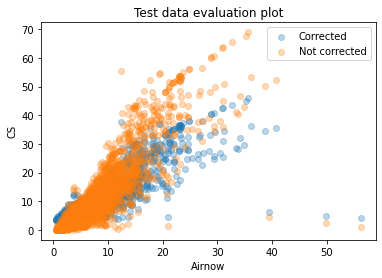

<IPython.core.display.Javascript object>

In [96]:
plt.scatter(y_test, y_hat_test, label="Corrected", alpha=0.3)
plt.scatter(y_test, test_data[["pm_cs"]], label="Not corrected", alpha=0.3)
plt.xlabel("Airnow")
plt.ylabel("CS")
plt.title("Test data evaluation plot")
plt.legend()
plt.show()

**We should only have only one model coefficient here, so we can't actually compare features. This step will be useful once we start scaling into more features**

**Now, let us evaluate and compare to baseline**

In [97]:
model_train_rmse = evaluate_model(y_train, y_hat_train)
model_test_rmse = evaluate_model(y_test, y_hat_test)

<IPython.core.display.Javascript object>

In [98]:
print(
    f"Resulting training evaluation is: {model_train_rmse} compared to baseline which is: {baseline_train_rmse}"
)

Resulting training evaluation is: {'RMSE': 3.34} compared to baseline which is: {'RMSE': 5.51}


<IPython.core.display.Javascript object>

In [99]:
print(
    f"Resulting test evaluation is: {model_test_rmse} compared to baseline which is: {baseline_test_rmse}"
)

Resulting test evaluation is: {'RMSE': 3.97} compared to baseline which is: {'RMSE': 7.08}


<IPython.core.display.Javascript object>

Our model reduces our error both in training and test compared to the baseline we obtained initially. This shows that we have already made meaningful progress using a linear model. It is a good start.

Now, let us observe the errors for each location (disaggregated).

In [100]:
model_disagg_train_metrics = get_disaggregated_metrics(training_data, y_hat_train)
model_disagg_test_metrics = get_disaggregated_metrics(test_data, y_hat_test)

<IPython.core.display.Javascript object>

In [101]:
print("Model training RMSE")
model_disagg_train_metrics["RMSE"]

Model training RMSE


{'NJH': {'RMSE': 2.28},
 'i25_glo_1': {'RMSE': 3.97},
 'i25_glo_2': {'RMSE': 3.57},
 'i25_glo_3': {'RMSE': 3.65},
 'la_casa': {'RMSE': 2.86}}

<IPython.core.display.Javascript object>

In [102]:
print("Model test RMSE")
model_disagg_test_metrics["RMSE"]

Model test RMSE


{'CAMP': {'RMSE': 1.64}, 'i25_denver': {'RMSE': 4.47}}

<IPython.core.display.Javascript object>

Our model reduces our RMSE error with respect to the baseline; we are correcting the low-cost sensor readings with about 50% reduction in error in `i25_denver` and 30% in `CAMP`. Data from these locations have not been seen by our model. There is some progress, right? See table below.

  | Location| Baseline RMSE| Linear model 1 RMSE|
  |---|---|---|
   |**Train**|---|---|
  |NJH | 4.36| 2.28|
  |i25_glo_1|6.67|3.97|
  |i25_glo_2|4.55|3.57|
  |i25_glo_3|5.41|3.65|
  |la_casa|6.06|2.86|
   |**Train**|---|---|
  |CAMP|2.35|1.64|
  |i25_denver|8.04|4.47|
  

# EXERCISE 

We need to repeat this process above for other feature sets defined in `model_features`.

For faster iterations, you can use `run_training_eval` function to iterate over features. Take not that the `run_training_eval` function also takes an `èstimator` argument which defaults to `LinearRegressor()`. You can change the value passed to this argument to `RandomForestRegressor` (which has alrready been imported into this notebook). This way, you can try they random forest model.  

Start with exploring all the possible features defined in `model_features` for `LinearRegressor()` before proceeding to `RandomForestRegressor`.

Find out what your best model is and deepen your exploration of this model using things like scatter plots for camparing corrected and not corrected `pm_cs`values. You model output is the corrected `pm_cs`value.

You can also find the feature importances by using `.feature_importances_`on your trained model. If you apply `run_training_eval`to fit your model, you will find the trained model in by using the `model`on the output dictionary.

You can then proceed to check for disaggregated errors for your best model.